## Naive Bayes Modeling and Metrics With TF-IDF Vectorier
---

**Library Imports**

In [224]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,accuracy_score,
    roc_auc_score, recall_score,
    precision_score, f1_score, classification_report, RocCurveDisplay)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB

from matplotlib.ticker import FuncFormatter

**Read in text_processed_corpus.csv**

In [95]:
text_processed_corpus = pd.read_csv('./data/text_processed_corpus.csv')

### Train Test Split and Null Model
---

In [96]:
#Train Test Split
X = text_processed_corpus['processed_text']
y = text_processed_corpus['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify = y,
                                                    random_state = 24)
                                                    
    

**What is the null model?**
* There is a **56%** chance of correctly predicting a post belongs in the fountainpens reddit.

In [97]:
y.value_counts(normalize = True) * 100

subreddit
1    55.615165
0    44.384835
Name: proportion, dtype: float64

In [98]:
#Ensuring that stratify is maintaining the slight skew between the two subreddit
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(subreddit
 1    0.556032
 0    0.443968
 Name: proportion, dtype: float64,
 subreddit
 1    0.556509
 0    0.443491
 Name: proportion, dtype: float64)

In [99]:
# Summon the vectorizers and estimators
cvec = CountVectorizer()
logreg = LogisticRegression()

#### Bernoulli Naive Bayes with CountVectorizer
___
In this project, I will use Bernoulli Naive Bayes as it is ideal to classify variables of 0 and 1.  This perfectly suits our problem of which subreddit posts belong.

In [100]:
# Build a pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bb', BernoulliNB())
])

In [101]:
# Checking an initial score without actually fitting anything.
cross_val_score(pipe, X_train, y_train, cv=3).mean()

0.8655221745350502

In [103]:
# Create parameters for a gridsearch over to see what performs best -  Started with2100 total models not including cv.
# Varied parameters until ideal parameters were determined.
pipe_params = {
    'bb__alpha':[0.5,0.75,1],
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [2,3, 4],
    'cvec__max_df': [0.7,0.8,0.9],
    'cvec__ngram_range': [(1,2), (1,3),(1,4)]
}

In [104]:
#GridSearch set-up
gs = GridSearchCV(pipe,
                  pipe_params,
                  cv = 5)

In [105]:
#GridSearch the training data.

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bb', BernoulliNB())]),
             param_grid={'bb__alpha': [0.5, 0.75, 1],
                         'cvec__max_df': [0.7, 0.8, 0.9],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 2), (1, 3), (1, 4)]})

In [106]:
#What was the best score?
print(f'The best accuracy score in all models tested in grid search is {round(gs.best_score_,2) * 100}%')

The best accuracy score in all models tested in grid search is 87.0%


In [107]:
# Breakdown of the parameters chosen to make the best model.  Liblinear was the only option added to pipe parameters.
gs.best_params_

{'bb__alpha': 0.75,
 'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3)}

### Predictions and Interpretation
___

Results - Model resulted in 90% for both the training and testing accuracy score which is the best of any attempted model.  Testing and training accuracy were both at 90%  The prediction accurary is 87%

#### Predictions

In [108]:
#Training set results
print(f'Training accuracy score is at {round(gs.score(X_train, y_train),2) * 100}%')

Training accuracy score is at 90.0%


In [109]:
# Testing set results - Null model is at 56%
print(f'Testing accuracy score is at {round(gs.score(X_test, y_test),2) * 100}%')

Testing accuracy score is at 90.0%


In [110]:
# The next two slides show how the model predicts (fountainpens = 1 and pens = 0) and the probability for each row value.
# First 20 samples are shown.
pred = gs.predict(X_test)
pred[:20]

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [226]:
gs.predict_proba(X_test)[:20]

array([[4.20908061e-01, 5.79091939e-01],
       [1.92679595e-02, 9.80732040e-01],
       [9.48873183e-04, 9.99051127e-01],
       [3.06938266e-03, 9.96930617e-01],
       [9.94608435e-01, 5.39156549e-03],
       [2.42965308e-02, 9.75703469e-01],
       [5.26356124e-01, 4.73643876e-01],
       [8.54828732e-02, 9.14517127e-01],
       [8.83872464e-02, 9.11612754e-01],
       [2.38316065e-03, 9.97616839e-01],
       [6.67558329e-17, 1.00000000e+00],
       [1.55384710e-05, 9.99984462e-01],
       [6.05319015e-08, 9.99999939e-01],
       [4.77592382e-01, 5.22407618e-01],
       [2.52244960e-09, 9.99999997e-01],
       [2.03433116e-01, 7.96566884e-01],
       [8.47798095e-04, 9.99152202e-01],
       [1.27468284e-07, 9.99999873e-01],
       [2.43374708e-01, 7.56625292e-01],
       [3.83640704e-03, 9.96163593e-01]])

In [227]:
# Accuracy Score - What precentage of total predictions were correct?
print(f'This model has an accuracy score of {round(metrics.accuracy_score(y_test, pred) * 100,2)}%')

This model has an accuracy score of 89.7%


## Confusion Matrix and Interpretation
-----
In this scenerio, I would ideally prefer to never incorrectly classify a pen subreddit post as a fountainpens post.  Pens are a more general topic and talking about fountain pens would be acceptable.  It's safe to assume people browsing the fountainpens subreddit are only interested in fountain pens.<br><br>
Essentially I want to mimimize false positives.  **The specificity score is ~91%** and this is the only model that handles false negatives better than false positives.<br>

In [112]:
#Create a confusion matrix array
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

print(tn, fp, fn, tp)

283 27 45 344


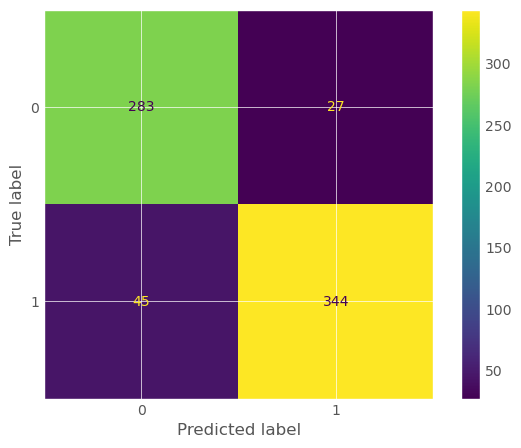

In [113]:
#Create a confusion matrix
#Create a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred),
                             display_labels=gs.classes_)

disp.plot();

In [114]:
# How sensitive is this model? ~88%
metrics.recall_score(y_test, pred)

0.884318766066838

In [115]:
# What is the specificity of the model?  - I care about this metric more and this is the best performing model for
# this metric.  Best score of all models at ~91%
tn / (tn + fp)

0.9129032258064517

In [116]:
# Recall is the same as sensitivity ~88%
metrics.recall_score(y_test, pred)

0.884318766066838

<Figure size 2000x800 with 0 Axes>

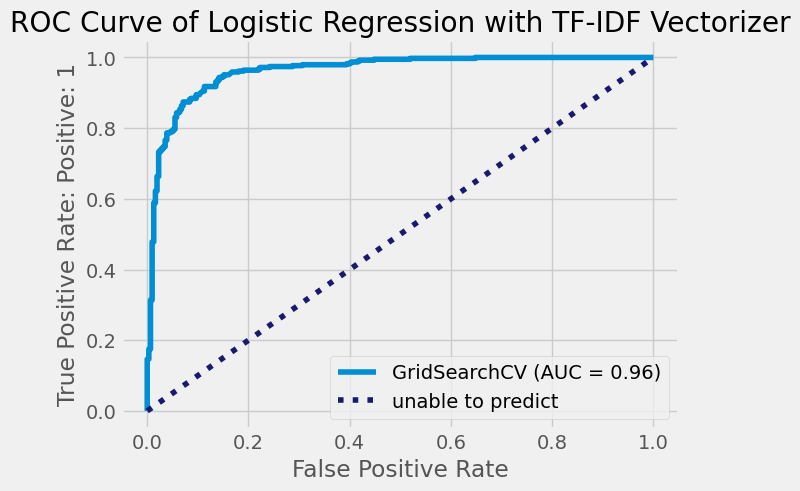

In [117]:
plt.figure(figsize = (20,8))
plt.style.use("fivethirtyeight")
plt.tight_layout()

RocCurveDisplay.from_estimator(gs, X_test, y_test)

# The 50/50 line
plt.plot([0,1], [0,1],
         label = 'unable to predict',
         linestyle = 'dotted',
         color = 'midnightblue');

# Legend
plt.legend()
plt.title('ROC Curve of Logistic Regression with TF-IDF Vectorizer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate: Positive: 1')
plt.savefig('./plot_images/logreg_cvec_roc_curve.png', dpi = 192);

In [118]:
#F1 Score - Unsure if this is meaningful because the classes weren't very unbalanced.
f1_score(y_test, pred)

0.9052631578947368

In [120]:
pred_df = pd.DataFrame(
    gs.predict_proba(X_test),
    columns=['pens', 'fountainpens'])

pred_df['true_values'] = y_test.values

pred_df.head()

,pens,fountainpens,true_values
0,0.420908,0.579092,1
1,0.019268,0.980732,1
2,0.000949,0.999051,1
3,0.003069,0.996931,1
4,0.994608,0.005392,0


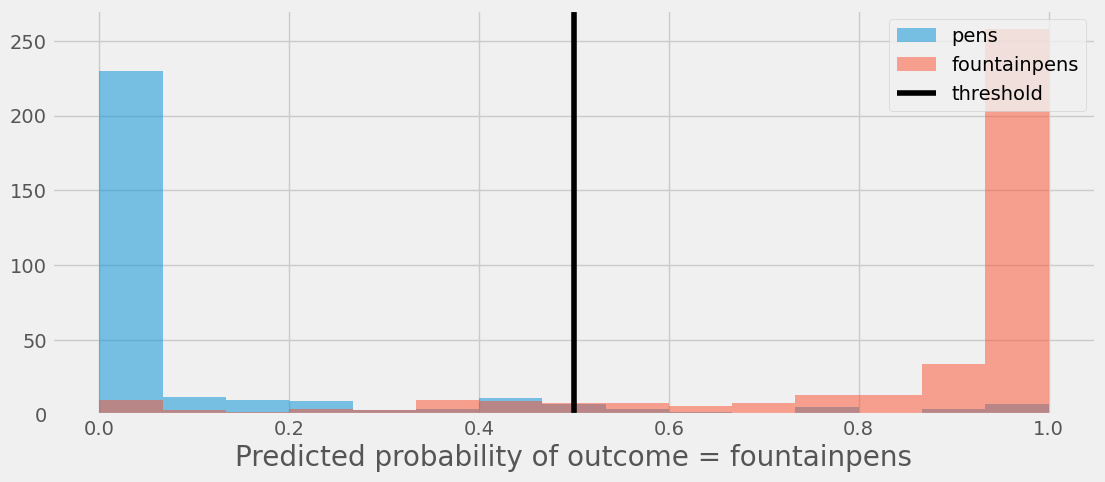

In [121]:
plt.figure(figsize=(12,5))
plt.tight_layout()

alive_subset = pred_df[pred_df['true_values'] == 0]
plt.hist(alive_subset['fountainpens'], label='pens', bins=15, alpha=.5)

dead_subset = pred_df[pred_df['true_values'] == 1]
plt.hist(dead_subset['fountainpens'], label='fountainpens', bins=15, alpha=.5)

plt.axvline(.5, color='black', linestyle='-', label='threshold')
plt.xlabel('Predicted probability of outcome = fountainpens', size = 20)

plt.legend();

In [126]:
cvec = CountVectorizer()

In [127]:
cvec.fit(X_train)

CountVectorizer()

In [129]:
X_train_words = cvec.transform(X_train)

In [130]:
X_test_words = cvec.transform(X_test)

In [132]:
type(X_train_words)

scipy.sparse._csr.csr_matrix

In [134]:
X_train_words.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

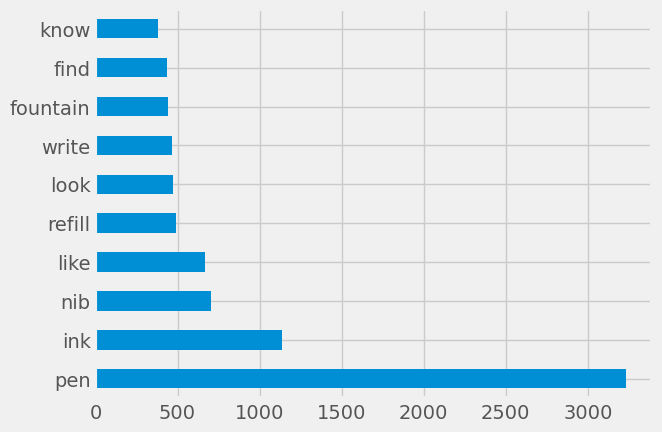

In [137]:
X_train_words_df = pd.DataFrame(X_train_words.todense(), 
                          columns=cvec.get_feature_names_out())

# plot top occuring words
X_train_words_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

In [223]:
pen_brands = ['pilot', 'sailor', 'twsbi', 'esterbrook', 'lamy', 'kaweco', 'visconti', 'benu', 'diplomat', 'edison', 'goulet', 'pelikan', 'platinum', 'schon', 'sheaffer', 'taccia']

pen_brands_count = X_train_words_df[pen_brands].sum()

Text(0, 0.5, 'Pen Brand')

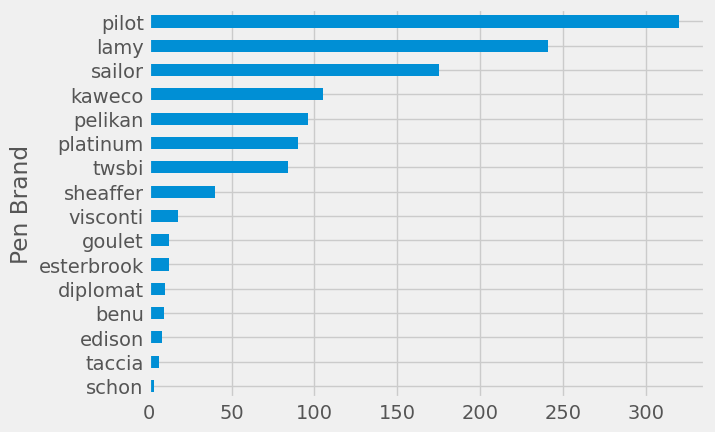

In [213]:
pen_brands_count.sort_values(ascending = True).plot(kind = 'barh', )

plt.ylabel('Pen Brand'.title()

In [143]:
X_train_words_df

,aaah,aaand,aantique,ab,abalone,abc,ability,abit,able,absent,...,zoom,zsolnay,zurich,éclat,émigré,夜桜,東京,根津神社,酒井抱一,金木犀
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
